In [1]:
from ai_assets import *

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array


def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test


def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_' +
                  group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_' +
                  group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_' +
                  group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group(
        'train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group(
        'test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ", trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

(470528, 9)


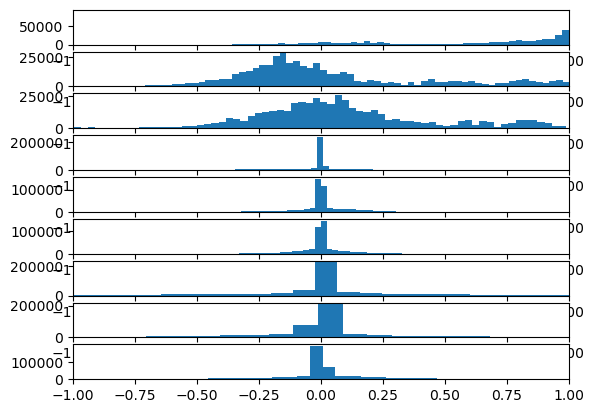

In [5]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

Set common parameters across all the models

In [6]:
# set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [13]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()

# GRU 레이어 추가
model.add(Bidirectional(GRU(units=32, input_shape=(
    n_timesteps, n_features), return_sequences=True)))
model.add(Bidirectional(GRU(16)))

model.add(Dense(64, activation='relu'))
model.add(Dense(units=n_outputs, activation='softmax'))

# 모델 빌드
model.build(input_shape=(None, n_timesteps, n_features))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 128, 64)          8256      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 18,630
Trainable params: 18,630
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [15]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size,
                    verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 13s 88ms/step - loss: 1.2681 - accuracy: 0.4870 - val_loss: 1.0498 - val_accuracy: 0.6220
Epoch 2/10
92/92 [==============================] - 7s 74ms/step - loss: 0.7548 - accuracy: 0.6948 - val_loss: 0.7347 - val_accuracy: 0.7274
Epoch 3/10
92/92 [==============================] - 7s 77ms/step - loss: 0.4918 - accuracy: 0.8072 - val_loss: 0.5553 - val_accuracy: 0.8545
Epoch 4/10
92/92 [==============================] - 7s 79ms/step - loss: 0.2586 - accuracy: 0.9133 - val_loss: 0.4679 - val_accuracy: 0.8613
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 0.1702 - accuracy: 0.9390 - val_loss: 0.3758 - val_accuracy: 0.8939
Epoch 6/10
92/92 [==============================] - 8s 90ms/step - loss: 0.1387 - accuracy: 0.9480 - val_loss: 0.4084 - val_accuracy: 0.8987
Epoch 7/10
92/92 [==============================] - 8s 88ms/step - loss: 0.1273 - accuracy: 0.9478 - val_loss: 0.4108 - val_accuracy: 0.9028
Epoch 8/10
9

Visualize the training process (loss) w.r.t train set and the validation set

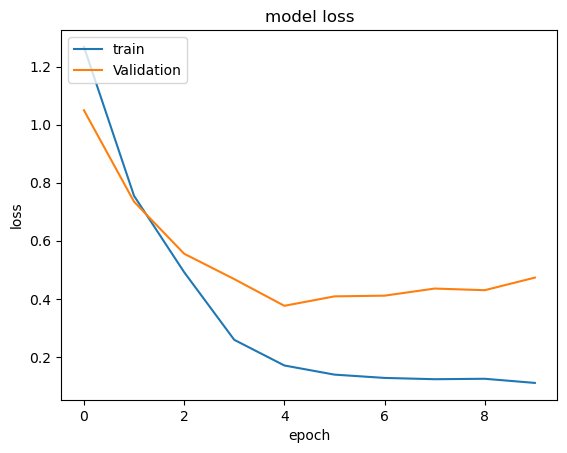

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [17]:
# evaluate model
test_loss, test_accuracy = model.evaluate(
    testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiGRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8863250613212585
93/93 [==============================] - 2s 15ms/step


In [18]:
predictions

array([[1.41944196e-02, 1.14088168e-03, 1.10727260e-05, 2.29231664e-03,
        9.82358396e-01, 2.88398701e-06],
       [5.00932429e-03, 3.16668302e-04, 3.52879761e-06, 2.52160337e-03,
        9.92146671e-01, 2.27750070e-06],
       [5.23399562e-03, 2.62882560e-04, 2.83375789e-06, 2.30654399e-03,
        9.92191255e-01, 2.50740959e-06],
       ...,
       [1.20672885e-04, 9.99794424e-01, 8.33144513e-05, 1.59219695e-08,
        1.33904564e-06, 1.73237694e-07],
       [1.87683516e-04, 9.99723375e-01, 8.62714951e-05, 1.14925296e-08,
        1.52202665e-06, 1.05703953e-06],
       [4.90592385e-04, 9.99442160e-01, 5.29530625e-05, 5.07098825e-08,
        8.22895527e-06, 6.05047808e-06]], dtype=float32)